In [1]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import data, exposure, img_as_float ,io,color
from six.moves import cPickle as pickle
from time import time
import os
%matplotlib inline

### Loading Data

In [2]:
train_filename='/Users/wasifaahmed/Documents/FRAS/TRAIN.tar.gz'

In [3]:
num_classes = 2
num_labels = 2
per_class_sample=6383
image_height=25
image_width=25
pixel_depth = 255.0
num_channels = 1

In [4]:
np.random.seed(133)
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] 
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)

    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

In [5]:
train_folders = maybe_extract(train_filename)

/Users/wasifaahmed/Documents/FRAS/TRAIN already present - Skipping extraction of /Users/wasifaahmed/Documents/FRAS/TRAIN.tar.gz.
['/Users/wasifaahmed/Documents/FRAS/TRAIN/notpierced2', '/Users/wasifaahmed/Documents/FRAS/TRAIN/pierced2']


### Pickle

In [6]:
class MacOSFile(object):

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)
    

    def read(self, n):
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                idx += batch_size
            return buffer
        return self.f.read(n)
    

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size


def load_letter(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_height, image_width),dtype=np.float32)
    image_index = 0
    for image in os.listdir(folder):
        image_file = os.path.join(folder, image)
        im=mpimg.imread(image_file).astype(float)
        image_data=color.rgb2gray(im)
        dataset[image_index, :, :] = image_data
        image_index += 1

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
        
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, MacOSFile(f), pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    
    return dataset_names

In [7]:
train_datasets = maybe_pickle(train_folders, 6383)

/Users/wasifaahmed/Documents/FRAS/TRAIN/notpierced2.pickle already present - Skipping pickling.
/Users/wasifaahmed/Documents/FRAS/TRAIN/pierced2.pickle already present - Skipping pickling.


In [8]:
import random
import hashlib

In [9]:
def disp_sample_pickles(data_folders):
    folder = random.sample(data_folders, 1)
    pickle_filename = ''.join(folder)
    try:
        with open(pickle_filename, 'rb') as f:
            print(pickle_filename)
            dataset = pickle.load(MacOSFile(f))
    except Exception as e:
        print('Unable to read data from', pickle_filename, ':', e)
    
    for i, img in enumerate(random.sample(list(dataset), 2)):
        plt.subplot(2, 1, i+1)
        plt.axis('off')
        plt.imshow(img)

/Users/wasifaahmed/Documents/FRAS/TRAIN/pierced2.pickle


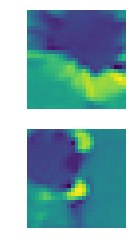

In [10]:
disp_sample_pickles(train_datasets)

In [11]:
def disp_number_images(data_folders):
    for folder in data_folders:
        pickle_filename = ''.join(folder)
        try:
            with open(pickle_filename, 'rb') as f:
                dataset = pickle.load(MacOSFile(f))
        except Exception as e:
            print('Unable to read data from', pickle_filename, ':', e)
            return
        print('Number of images in ', folder, ' : ', len(dataset))

In [12]:
disp_number_images(train_datasets)

Number of images in  /Users/wasifaahmed/Documents/FRAS/TRAIN/notpierced2.pickle  :  6383
Number of images in  /Users/wasifaahmed/Documents/FRAS/TRAIN/pierced2.pickle  :  10880


### Prepare for Training ,Valid and Test

In [13]:
def make_arrays(nb_rows, image_height, image_width):
    if nb_rows:
        dataset = np.ndarray((nb_rows, image_height, image_width), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [14]:
def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_height, image_width)
    train_dataset, train_labels = make_arrays(train_size, image_height, image_width)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(MacOSFile(f))
                np.random.shuffle(letter_set)
            if valid_dataset is not None:
                valid_letter = letter_set[:vsize_per_class, :, :]
                valid_dataset[start_v:end_v, :, :] = valid_letter
                valid_labels[start_v:end_v] = label
                start_v += vsize_per_class
                end_v += vsize_per_class
                    
            train_letter = letter_set[vsize_per_class:end_l, :, :]
            train_dataset[start_t:end_t, :, :] = train_letter
            train_labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    return valid_dataset, valid_labels, train_dataset, train_labels

In [15]:
train_size = num_classes*per_class_sample
valid_size = 1
test_size = num_classes*per_class_sample

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(train_datasets
                                                 , test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (12766, 25, 25) (12766,)
Validation: (1, 25, 25) (1,)
Testing: (12766, 25, 25) (12766,)


In [16]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    
    return shuffled_dataset, shuffled_labels

In [17]:
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [18]:
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_height*image_width)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

In [19]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset_1, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset_1.shape, test_labels.shape)

Training set (12766, 625) (12766, 2)
Validation set (1, 625) (1, 2)
Test set (12766, 625) (12766, 2)


### Building Models

In [20]:
import tensorflow as tf

In [21]:
batch_size = 60
epoch = 500
gd= 0.5
hidden_layers = 30
num_steps = (epoch*train_size)//batch_size
print_step_epoch=100
print_step=(print_step_epoch*train_size)//batch_size

In [22]:
graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_height*image_width))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset_1)
    tf_test_image = tf.placeholder(tf.float32, shape=(1,image_height*image_width), name = 'tf_test_image')
    
    weights_1= tf.Variable(tf.truncated_normal([image_width * image_height,num_labels]))
    biases_1 = tf.Variable(tf.zeros([num_labels]))
    
    def model(data):
        fullyconnected = tf.matmul(data,weights_1) + biases_1
        return fullyconnected
  
    
    logits = model(tf_train_dataset)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    optimizer =  tf.train.GradientDescentOptimizer(gd).minimize(loss)
    train_prediction = tf.nn.softmax(logits ,name = 'predict')
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    test_prediction_image = tf.nn.softmax(model(tf_test_image) ,name = 'test_prediction_image')
    print(test_prediction_image)

Tensor("test_prediction_image:0", shape=(1, 2), dtype=float32)


In [23]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])


with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized...")
    t0 = time()
    model_saver=tf.train.Saver()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions= session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % print_step == 0):
            BA=accuracy(predictions, batch_labels)
            TA=accuracy(test_prediction.eval(), test_labels)
            VA=0
            epoch_no = (batch_size*step)//train_size
            tt=round(time() - t0, 0)
            print("@epoch %d [TT: %d Sec] : L=%f, BA=%0.1f%%, VA=%0.1f%%, TA=%0.1f%%" % (epoch_no,tt,l,BA,VA,TA)) 
            
    model_saver.save(session, '/Users/wasifaahmed/Documents/FRAS/Simulation/FRAS_20170726/FRAS_20170727')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    labels=(np.argmax(test_prediction.eval(), 1))

Initialized...
@epoch 0 [TT: 0 Sec] : L=1.582777, BA=33.3%, VA=0.0%, TA=52.7%
@epoch 99 [TT: 17 Sec] : L=0.002105, BA=100.0%, VA=0.0%, TA=99.9%
@epoch 199 [TT: 35 Sec] : L=0.000664, BA=100.0%, VA=0.0%, TA=99.9%
@epoch 299 [TT: 50 Sec] : L=0.005308, BA=100.0%, VA=0.0%, TA=100.0%
@epoch 399 [TT: 65 Sec] : L=0.000902, BA=100.0%, VA=0.0%, TA=100.0%
@epoch 499 [TT: 80 Sec] : L=0.001950, BA=100.0%, VA=0.0%, TA=100.0%
Test accuracy: 100.0%


In [25]:
pretty_labels ={
                0: 'Not Pierced',
                1:'Pierced'
}

def disp_sample_dataset(dataset, labels):
  items = random.sample(range(len(labels)), 64)
  plt.figure(figsize=(20,15))
  for i, item in enumerate(items):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.title(pretty_labels[labels[item]])
    plt.imshow(dataset[item],cmap='gray')

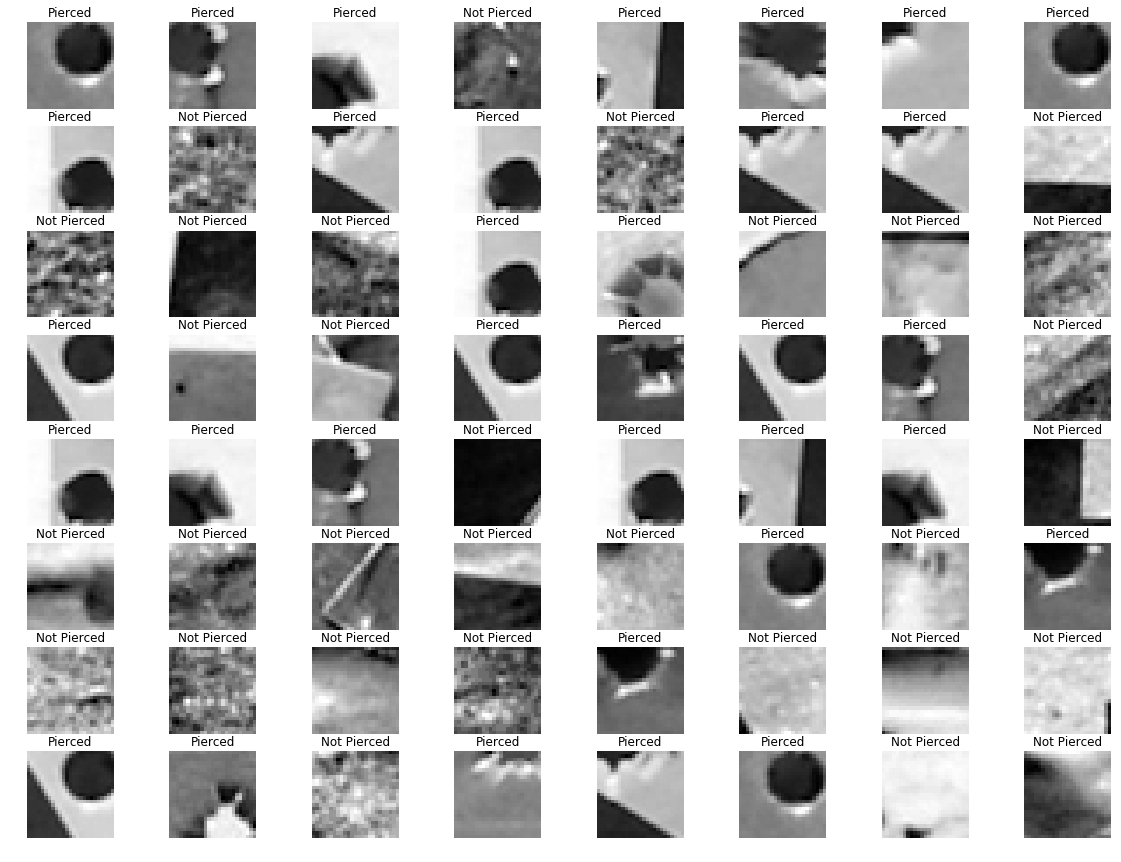

In [26]:
disp_sample_dataset(test_dataset,labels)